In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

root_dir = "/content/drive/My Drive/"

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [4]:
!pip install timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [33]:
class ASLDataset(Dataset):
  def __init__(self, data_dir, transform = None):
    self.data = ImageFolder(data_dir, transform = transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [34]:
dataset = ASLDataset(data_dir = '/content/asl_alphabet_train/asl_alphabet_train')

In [7]:
len(dataset)

87000

1


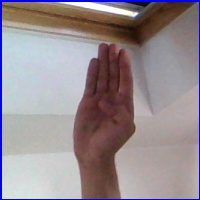

In [8]:
image, label = dataset[3200]
print(label)
image

In [9]:
data_dir = '/content/asl_alphabet_train/asl_alphabet_train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}


In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [12]:
data_dir = '/content/asl_alphabet_train/asl_alphabet_train'
dataset = ASLDataset(data_dir = data_dir, transform = transform)

In [13]:
image, label = dataset[3200]
image.shape

torch.Size([3, 128, 128])

In [14]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [15]:
for images, labels in dataloader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [16]:
labels

tensor([ 4, 17, 16, 23, 14, 10, 14, 19,  6, 17, 26, 24,  9, 24, 17, 24, 13, 18,
        11,  7,  6,  9,  2, 18, 18, 15, 15,  6, 13, 21,  1, 11])

In [17]:
class ASLSignClassifier(nn.Module):
  def __init__(self, num_classes = 29):
    super(ASLSignClassifier, self).__init__()
    self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    enet_out_size = 1280
    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(enet_out_size, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    output = self.Classifier(x)
    return output

In [18]:
model = ASLSignClassifier()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [19]:
print(str(model)[:500])

ASLSignClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [21]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/asl_alphabet_train/asl_alphabet_train'
test_folder = '/content/asl_alphabet_test/asl_alphabet_test'

train_dataset = ASLDataset(data_dir = train_folder, transform = transform)
# test_dataset = ASLDataset(data_dir = test_folder, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [22]:
# simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ASLSignClassifier(num_classes = 29)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc = 'Training loop'):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * labels.size(0)

  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)


Training loop:   0%|          | 0/2719 [00:00<?, ?it/s]

Training loop:   0%|          | 0/2719 [00:00<?, ?it/s]

Training loop:   0%|          | 0/2719 [00:00<?, ?it/s]

Training loop:   0%|          | 0/2719 [00:00<?, ?it/s]

Training loop:   0%|          | 0/2719 [00:00<?, ?it/s]

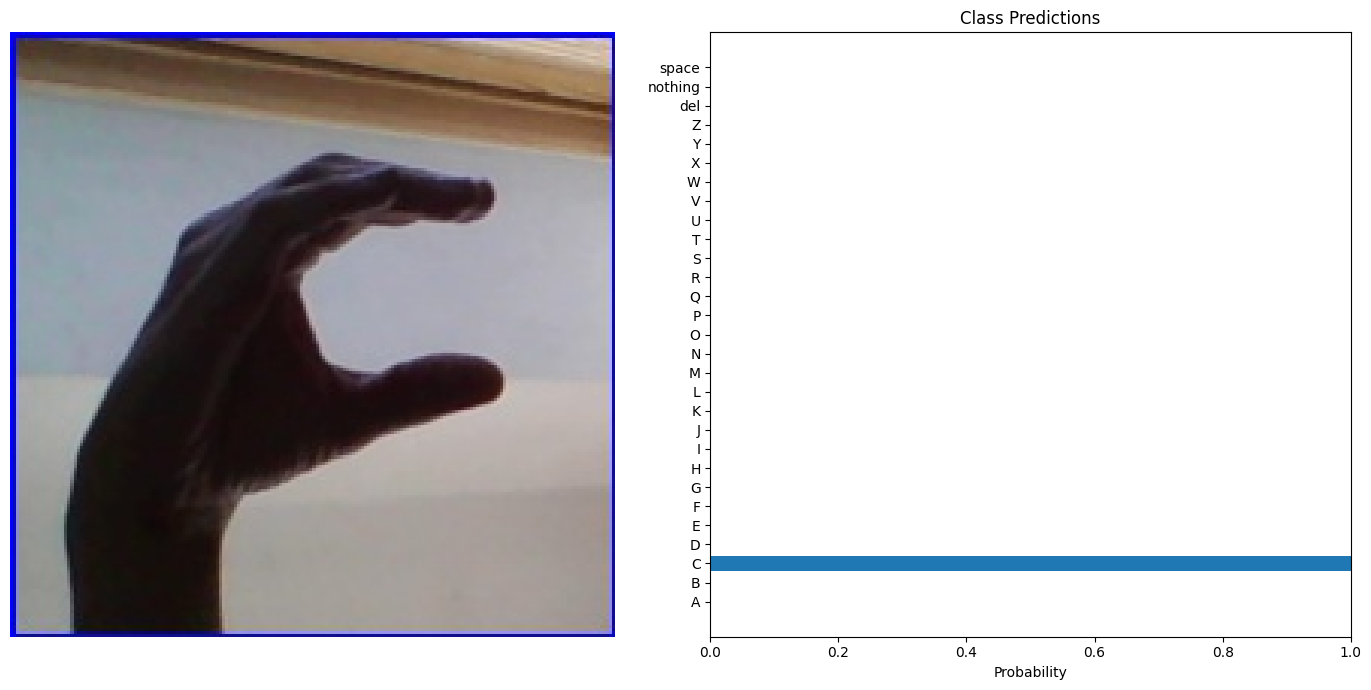

In [39]:

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Load and preprocess the image

def preprocess_image(image_path, transform):
  image = Image.open(image_path).convert('RGB')
  return (image, transform(image).unsqueeze(0))


# Predict using the model

def predict(model, image_tensor, device):
  model.eval()
  with torch.no_grad():
      image_tensor = image_tensor.to(device)
      outputs = model(image_tensor)
      probabilities = torch.nn.functional.softmax(outputs, dim=1)
  return probabilities.cpu().numpy().flatten()


# Visualization

def visualize_predictions(original_image, probabilities, class_names):
  (fig, axarr) = plt.subplots(1, 2, figsize=(14, 7))

  # Display image

  axarr[0].imshow(original_image)
  axarr[0].axis('off')

  # Display predictions

  axarr[1].barh(class_names, probabilities)
  axarr[1].set_xlabel('Probability')
  axarr[1].set_title('Class Predictions')
  axarr[1].set_xlim(0, 1)

  plt.tight_layout()
  plt.show()


# Example usage

test_image = '/content/asl_alphabet_test/asl_alphabet_test/C_test.jpg'
transform = transforms.Compose([transforms.Resize((128, 128)),
                               transforms.ToTensor()])

(original_image, image_tensor) = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)
